In [409]:
import time
import warnings
from tqdm.notebook import tqdm
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRanker, Pool, MetricVisualizer
from copy import deepcopy

import pandas as pd
import scipy.stats as sps

# Тестовое задание

---

### Обзор

In [387]:
data = pd.read_csv('intern_task.csv')

In [360]:
data.head()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000


In [361]:
data.describe()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
count,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,...,2.352580e+05,2.352580e+05,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000
mean,0.677869,14828.413401,1.911960,0.206233,1.189847,0.550272,1.960082,0.803964,0.097557,0.541174,...,4.763432e+02,1.046698e+04,0.070299,0.740710,11.067947,0.281747,0.027033,0.000269,22.457910,9.560379
std,0.830033,8193.945170,1.237374,0.579089,1.037233,0.790947,1.203534,0.339955,0.266035,0.419973,...,1.954840e+04,2.649584e+06,0.100721,0.352800,15.336861,0.392089,0.033351,0.002088,63.708018,14.347378
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8215.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.666667,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.620522,0.000000,0.000000,0.006703,0.000000,4.000000,2.000000
50%,0.000000,14935.000000,2.000000,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.500000,...,0.000000e+00,0.000000e+00,0.000000,0.926779,9.448900,0.000000,0.017761,0.000008,12.000000,5.500000
75%,1.000000,21580.000000,3.000000,0.000000,2.000000,1.000000,3.000000,1.000000,0.000000,1.000000,...,1.000000e+00,4.000000e-01,0.142857,0.999613,16.146733,0.500000,0.034954,0.000109,28.000000,12.000000
max,4.000000,29995.000000,31.000000,18.000000,27.000000,9.000000,31.000000,1.000000,1.000000,1.000000,...,1.731553e+06,8.000000e+08,0.818182,1.000000,2506.799764,1.000000,0.711261,0.250000,15074.000000,1552.000000


In [362]:
print(f'Кол-во пропусков: {data.isna().sum().sum()}')

Кол-во пропусков: 0


### Анализ фич

В нашем случае, размер выборки не мал. Если размер выборки велик, а распределение признаков не нормальное, то коэффициент корреляции Пирсона выборки остается примерно несмещенным, но может быть неэффективным.

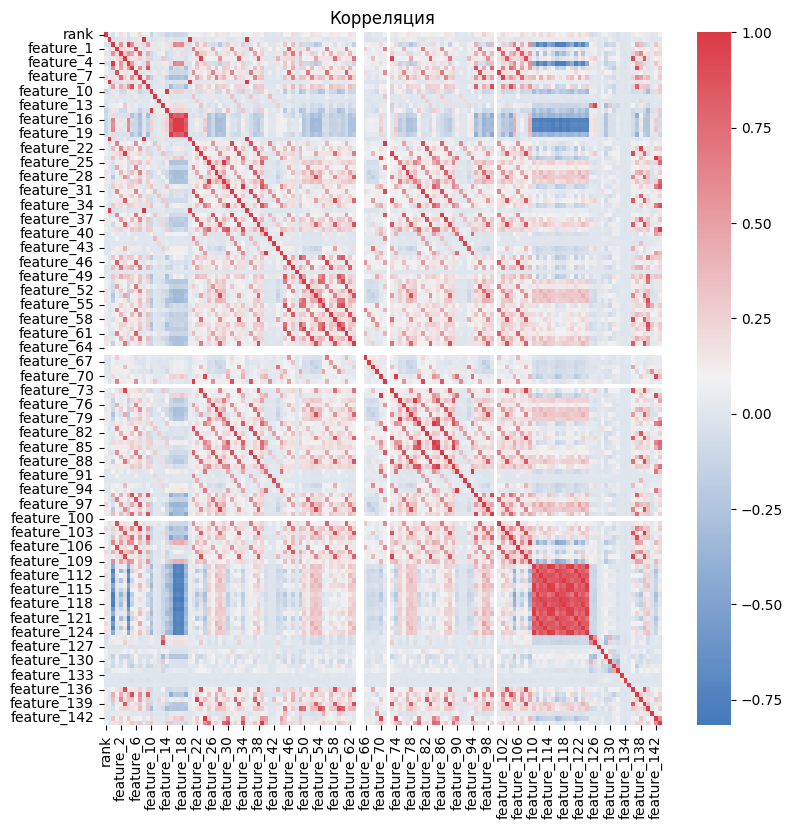

In [58]:
plt.figure(figsize=(9, 9))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(data.corr(), cmap=cmap)
plt.title("Корреляция")
plt.show()

Заметим, что есть фичи:
1. которые вообще не коррелируют;
2. которые сильно коррелируют с некоторыми (может быть линейная зависимость между ними $\rightarrow$ мультиколлинеарность); Возможно, это одна и та же фича (по смыслу), но в другом формате или представлении

Посмотрим отдельно на них

In [363]:
useless_feats = []

for i in range(144):
    feat = f'feature_{i}'
    minn = data[feat].min()
    maxx = data[feat].max()
    if np.isclose(minn, maxx) or data[feat].std() < 0.0001:
        useless_feats.append(feat)
        print(f'Неинформативный признак {feat}: мин. {minn}, макс. {maxx}')
        
useless_feats

Неинформативный признак feature_64: мин. 0, макс. 0
Неинформативный признак feature_65: мин. 0, макс. 0
Неинформативный признак feature_72: мин. 1, макс. 1
Неинформативный признак feature_100: мин. 0, макс. 0


['feature_64', 'feature_65', 'feature_72', 'feature_100']

Удалим их

In [388]:
data = data.drop(columns=useless_feats)

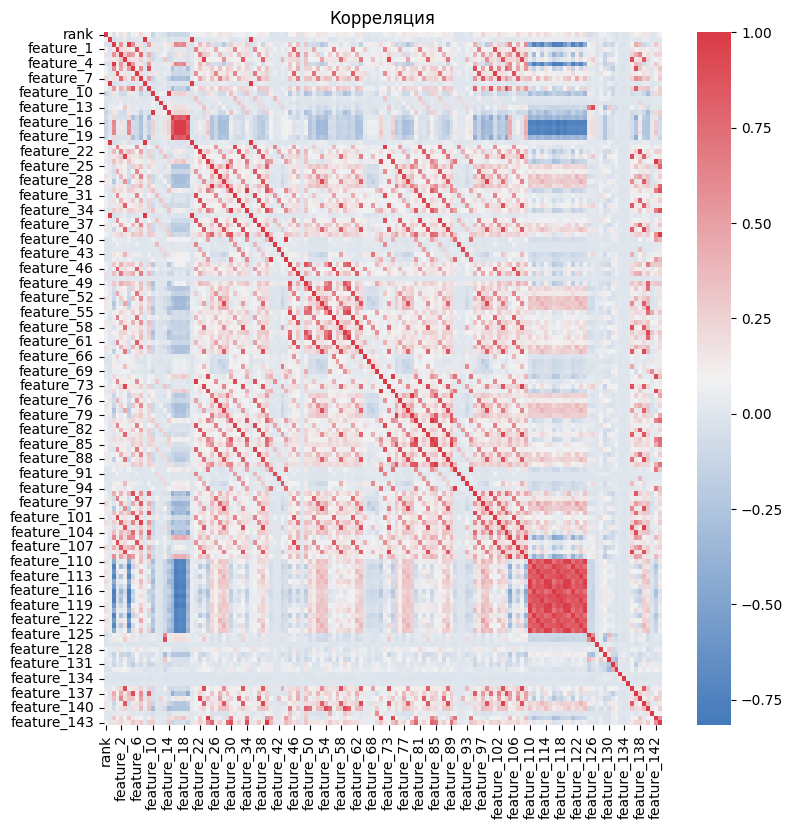

In [87]:
plt.figure(figsize=(9, 9))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(data.corr(), cmap=cmap)
plt.title("Корреляция")
plt.show()

Попробуем задетектить категориальные признаки. Целочисленных признаков много. Пусть это будут те признаки, у которых всего макс. 3 значения

In [389]:
cat_feats = []

for feat in data.columns:
    unique_a = np.unique(data[feat]) 
    if (unique_a.astype(int) == unique_a).sum() == len(unique_a) and len(unique_a) < 4 and feat != 'rank':             
        print(f'Предположительно категориальная {feat} имеет {len(unique_a)} значений {np.unique(data[feat])}')
        cat_feats.append(feat)

Предположительно категориальная feature_95 имеет 2 значений [0. 1.]
Предположительно категориальная feature_96 имеет 2 значений [0. 1.]
Предположительно категориальная feature_97 имеет 2 значений [0. 1.]
Предположительно категориальная feature_98 имеет 2 значений [0. 1.]
Предположительно категориальная feature_99 имеет 2 значений [0. 1.]


Если же нет, то их много

In [355]:
cat_feats = []

for feat in data.columns:
    unique_a = np.unique(data[feat]) 
    if (unique_a.astype(int) == unique_a).sum() == len(unique_a) and len(unique_a) < 30 and feat != 'rank':             
        print(f'Предположительно категориальная {feat} имеет {len(unique_a)} значений {np.unique(data[feat])}')
        cat_feats.append(feat)

Предположительно категориальная feature_0 имеет 16 значений [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 24. 26. 27. 31.]
Предположительно категориальная feature_1 имеет 10 значений [ 0.  1.  2.  3.  4.  5.  6.  7.  9. 18.]
Предположительно категориальная feature_2 имеет 15 значений [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 19. 20. 22. 24. 27.]
Предположительно категориальная feature_3 имеет 10 значений [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Предположительно категориальная feature_4 имеет 16 значений [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 24. 26. 27. 31.]
Предположительно категориальная feature_23 имеет 13 значений [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 12. 42.]
Предположительно категориальная feature_26 имеет 26 значений [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 22. 24. 25. 28. 49. 52.]
Предположительно категориальная feature_27 имеет 24 значений [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  21.  

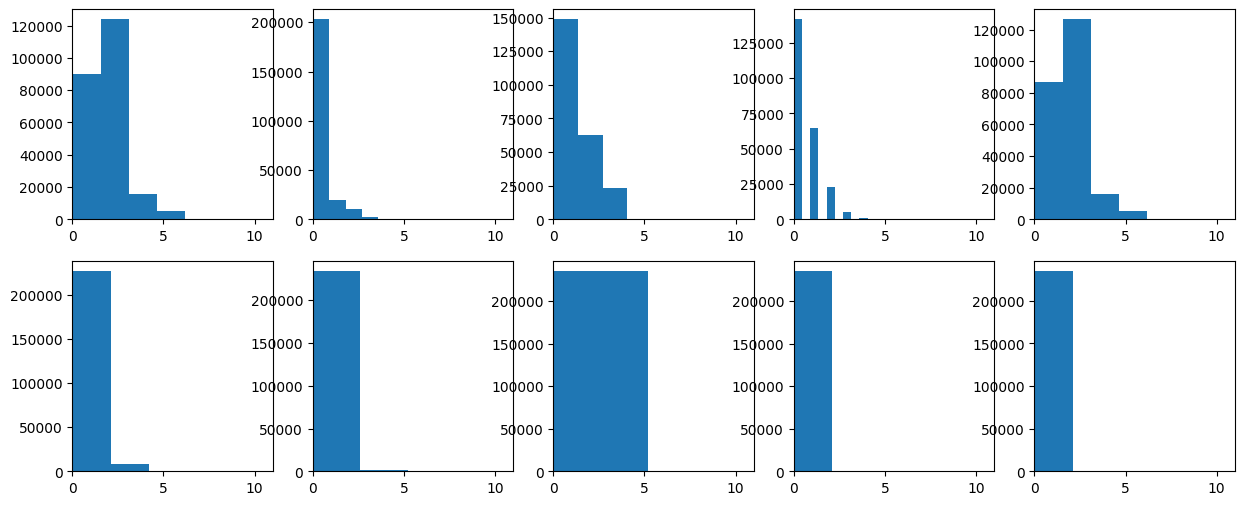

In [318]:
plt.figure(figsize=(15, 6))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.hist(data[cat_feats[i]], bins=20)
    plt.xlim(0, 11)

Причем у некоторых есть критические значения которых мало. Так как у нас нет описания признаков, я тоже ничего не буду с ними делать + не уверен что они вообще категориальные

Пока возьмем за категориальные фичи у которых всего 2 значения

In [390]:
cat_data = data[cat_feats].astype(int)
data = data.drop(columns=cat_feats)

In [394]:
cat_data.describe()

,feature_95,feature_96,feature_97,feature_98,feature_99
count,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000
mean,0.699912,0.061779,0.383192,0.184946,0.733046
std,0.458297,0.240754,0.486166,0.388254,0.442369
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


*Что касается выбросов (если они есть)*: Их можно задетектить с помощью Robust Random Cut Forest или других методов. Но так как у нас нет никакого описания признаков, я не буду этого делать.

---

# Подход 1: PCA

In [395]:
Y_data = data['rank']
Q_data = data['query_id']
X_data = data.drop(columns=['rank', 'query_id'])

In [396]:
scaler = StandardScaler()
scaled_X_data = scaler.fit_transform(X_data)

In [397]:
pca = PCA(n_components=70)
pca.fit(scaled_X_data)

PCA(n_components=70)

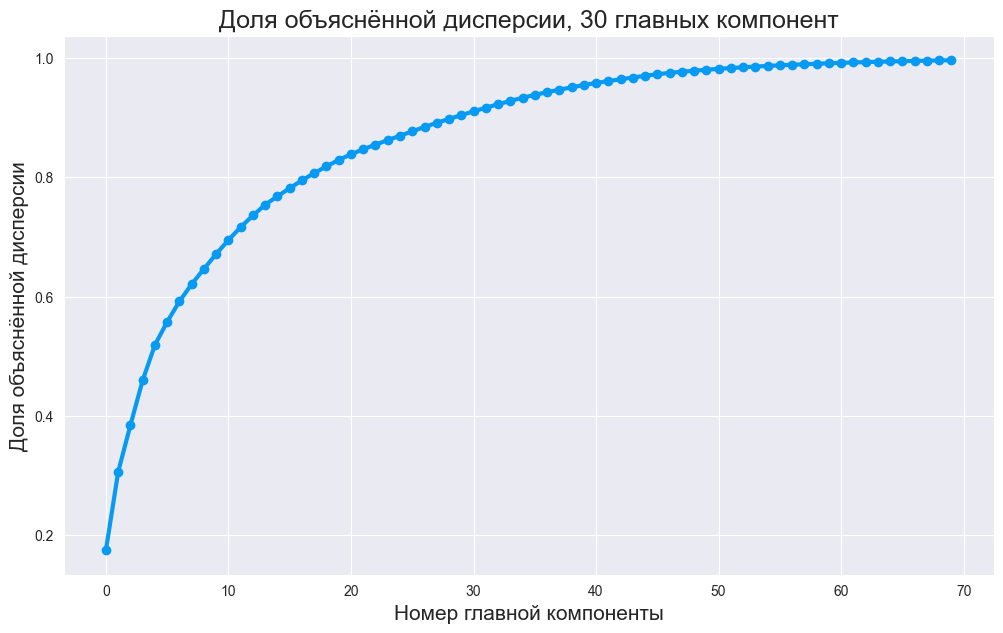

In [371]:
sns.set_style('darkgrid')

plt.figure(figsize=(12, 7))
plt.title("Доля объяснённой дисперсии, 30 главных компонент", fontsize=18)
plt.scatter(np.arange(70), pca.explained_variance_ratio_.cumsum(), color="xkcd:azure");
plt.plot(np.arange(70), pca.explained_variance_ratio_.cumsum(), color="xkcd:azure", lw=3);
plt.xlabel("Номер главной компоненты", fontsize=15)
plt.ylabel("Доля объяснённой дисперсии", fontsize=15)
plt.show()

Выберем 30 компонент

In [398]:
n_components=30

In [399]:
pca = PCA(n_components=n_components)
scaled_tranformed_X = pca.fit_transform(scaled_X_data)

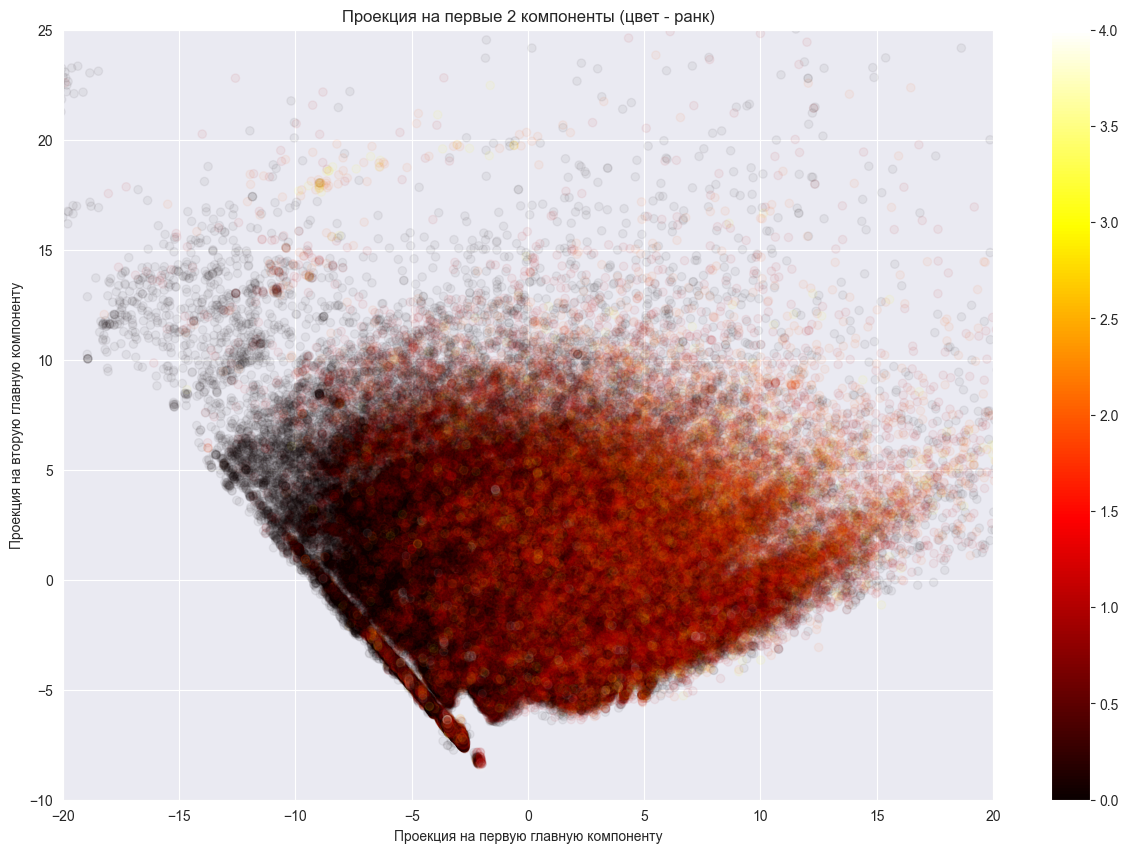

In [164]:
pca = PCA(n_components=3)
Y = pca.fit_transform(scaled_X_data)
plt.figure(figsize=(15, 10))
p = plt.scatter(Y[:, 0], Y[:, 1], c=Y_data, cmap='hot', alpha=1)
plt.xlabel('Проекция на первую главную компоненту')
plt.ylabel('Проекция на вторую главную компоненту')
plt.title('Проекция на первые 2 компоненты (цвет - ранк)')
plt.colorbar()
p.set_alpha(0.05)
plt.xlim(-20, 20)
plt.ylim(-10, 25)
plt.show()

Заметно смещение по рангу

### Распределение рангов

In [33]:
data.groupby('rank')['query_id'].count()

rank
0    121521
1     75815
2     31910
3      4209
4      1803
Name: query_id, dtype: int64

<Axes: >

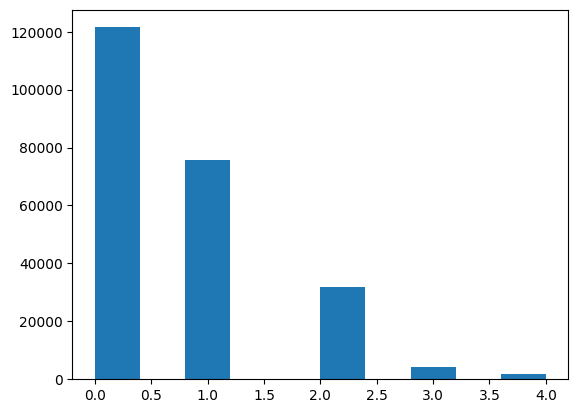

In [32]:
data['rank'].hist(grid=False)

### Подготовка к обучению

In [400]:
X_df = pd.DataFrame(scaled_tranformed_X)
X_df = pd.concat([X_df, cat_data], axis=1)
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,feature_95,feature_96,feature_97,feature_98,feature_99
0,4.052559,2.344586,-9.747515,-3.416371,1.336300,-3.534182,0.909853,0.955754,-1.093650,1.376543,...,0.481645,0.443001,-0.790212,0.224718,0.210397,0,0,0,1,1
1,-0.432786,2.264945,3.081714,-1.804683,-2.302030,0.409672,0.450202,-1.160240,-0.467964,0.512443,...,0.456183,-0.097789,0.035260,-0.079186,-0.336915,1,0,1,0,1
2,-2.645617,1.129820,1.719140,-0.952188,-1.674765,0.443441,-0.317642,-1.520690,-0.558013,0.809746,...,0.205390,0.058879,-0.715135,0.027974,-0.107361,1,0,0,0,1
3,-0.452983,1.162849,2.626443,-2.370404,-4.113124,-1.693650,-0.483230,-1.024103,0.312562,0.223809,...,-0.151399,0.235016,-0.685010,0.099374,-0.090544,1,0,1,0,1
4,2.739472,3.112070,-1.074635,-3.516672,-2.758475,-0.750276,2.074385,-1.620698,-1.663656,1.713078,...,-0.413488,0.618380,-0.633021,0.010630,-0.101809,1,0,1,0,1


In [375]:
Q_data.unique().shape

(2000,)

Всего 2000 сессии. На оценку качества отведем 200 (10%).

In [401]:
Q_test_indexes = np.random.choice(Q_data.unique(), size=200, replace=False)
Q_train_indexes = np.array([i for i in Q_data.unique() if i not in Q_test_indexes])
assert(Q_train_indexes.shape[0] == 1800 and Q_test_indexes.shape[0] == 200)

In [402]:
X_train_df = X_df.loc[np.where(Q_data.isin(Q_train_indexes))]
X_test_df = X_df.loc[np.where(Q_data.isin(Q_test_indexes))]

y_train = Y_data.loc[np.where(Q_data.isin(Q_train_indexes))]
y_test = Y_data.loc[np.where(Q_data.isin(Q_test_indexes))]

Q_train = Q_data.loc[np.where(Q_data.isin(Q_train_indexes))]
Q_test = Q_data.loc[np.where(Q_data.isin(Q_test_indexes))]

In [403]:
X_train_df.columns = X_train_df.columns.astype(str)
X_test_df.columns = X_test_df.columns.astype(str)

In [382]:
X_train_df.shape

(209800, 35)

Убедимся, что распределение классов одинаково

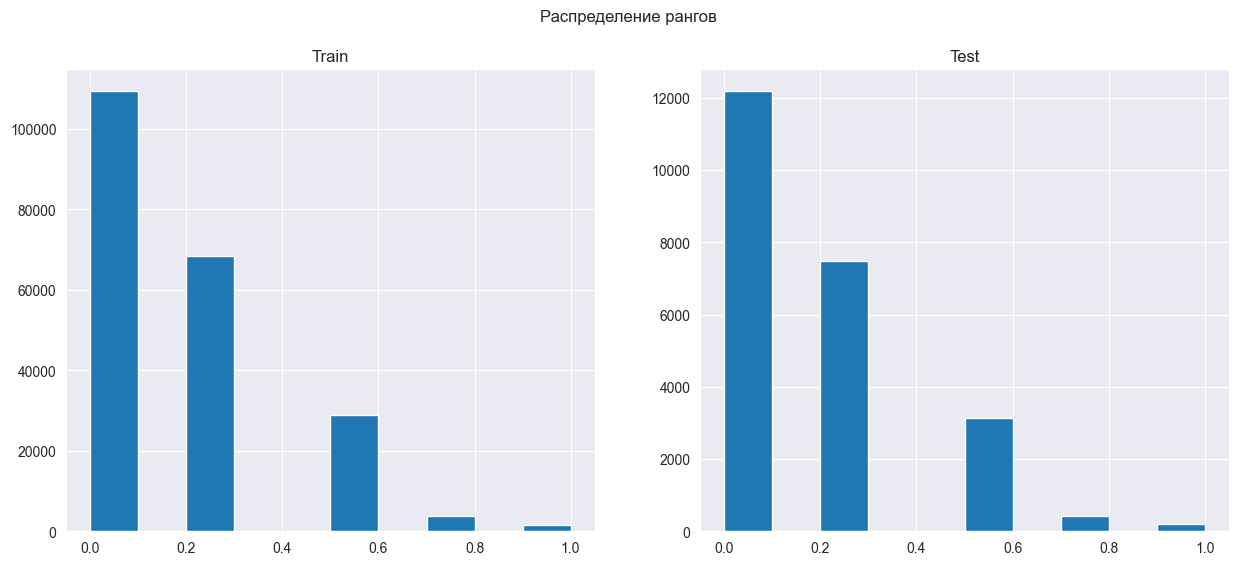

In [490]:
plt.figure(figsize=(15, 6))
plt.suptitle('Распределение рангов')
plt.subplot(121)
plt.title('Train')
y_train.hist()
plt.subplot(122)
plt.title('Test')
y_test.hist()
plt.show()

Они *почти* совпадают, т.к. мы брали рандомное разбиение

### Обучение

#### CatBoostRanker

Для подсчета метрик отобразим ранги на отрезок [0, 1]

In [404]:
max_rank = np.max(Y_data)
y_train /= max_rank
y_test /= max_rank

In [405]:
train = Pool(
    data=X_train_df,
    label=y_train,
    group_id=Q_train,
    cat_features=np.array(cat_data.columns)
)

test = Pool(
    data=X_test_df,
    label=y_test,
    group_id=Q_test,
    cat_features=np.array(cat_data.columns)
)

In [510]:
params = {
    'iterations': 2000,
    'custom_metric': ['NDCG:top=5', 'NDCG:top=10', 'PFound', 'PrecisionAt:top=5', 'MAP:top=5'],
    'verbose': False,
    'random_seed': 42,
}

In [511]:
def train_ranker(loss_function, plot=False):
    parameters = deepcopy(params)
    parameters['loss_function'] = loss_function
    parameters['train_dir'] = loss_function

    model = CatBoostRanker(**parameters)
    model.fit(train, eval_set=test, plot=plot, use_best_model=True)
    
    return model.best_score_

In [527]:
def dict_to_dataframe(metrics_dict, model_name, df=None):
    learn_metrics = metrics_dict.get('learn', {})
    validation_metrics = metrics_dict.get('validation', {})
    
    df_learn = pd.DataFrame(learn_metrics, index=[model_name])
    df_valid = pd.DataFrame(validation_metrics, index=[model_name])
    
    df_learn.columns = [col for col in df_learn.columns]
    df_valid.columns = [col for col in df_valid.columns]
    
    d = {'Train' : df_learn, 'Test' : df_valid}
    
    df_concat = pd.concat(d.values(), axis=1, keys=d.keys())
    if df is not None:
        df_concat = pd.concat([df, df_concat], axis=0)
    return df_concat

In [533]:
losses = ['RMSE', 'QueryRMSE', 'PairLogit', 'YetiRank']

In [534]:
result_df = None
for loss_func in tqdm(losses):
    metrics = train_ranker(loss_func)
    if result_df is None:
        result_df = dict_to_dataframe(metrics, loss_func)
    else:
        result_df = dict_to_dataframe(metrics, loss_func, result_df)

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\ztimu\anaconda3\lib\site-packages\catboost\core.py:6219: RuntimeWarning: Regression loss ('RMSE') ignores an important ranking parameter 'group_id'
  warnings.warn("Regression loss ('{}') ignores an important ranking parameter 'group_id'".format(loss_function), RuntimeWarning)


Метрики качества для разных loss функции

In [600]:
result_df.index.name = 'CatBoostRanker'

In [601]:
np.round(result_df['Train'][['MAP:top=5', 'PrecisionAt:top=5']], 2)

,MAP:top=5,PrecisionAt:top=5
CatBoostRanker,,
RMSE,0.23,0.19
QueryRMSE,0.17,0.15
PairLogit,0.11,0.11
YetiRank,0.19,0.16


In [602]:
np.round(result_df['Test'][['NDCG:top=10;type=Base', 'PFound', 'NDCG:top=5;type=Base', 'MAP:top=5', 'PrecisionAt:top=5']], 2)

,NDCG:top=10;type=Base,PFound,NDCG:top=5;type=Base,MAP:top=5,PrecisionAt:top=5
CatBoostRanker,,,,,
RMSE,0.48,0.68,0.48,0.11,0.10
QueryRMSE,0.50,0.68,0.48,0.12,0.10
PairLogit,0.49,0.66,0.47,0.10,0.10
YetiRank,0.50,0.69,0.50,0.13,0.11


#### Корректность: подадим на вход неинформативные данные.

In [566]:
probs = y_train.value_counts().values / y_train.value_counts().sum()

In [567]:
probs

array([0.51606493, 0.32253527, 0.13585451, 0.0179223 , 0.00762299])

In [582]:
X_df_dummy = np.random.random(size=(211859, 35))
y_dummy = np.random.choice([0, 0.25, 0.5, 0.75, 1], p=probs, replace=True, size=211859)

In [583]:
X_df_dummy = pd.DataFrame(X_df_dummy).rename(columns={30: 'feature_95', 31: 'feature_96', 32: 'feature_97', 33: 'feature_98', 34: 'feature_99'})

In [584]:
for feat in cat_feats:
    X_df_dummy[feat] = sps.bernoulli.rvs(size=211859, p=0.5)

In [586]:
dummy = Pool(
    data=X_df_dummy,
    label=y_dummy,
    group_id=Q_train,
    cat_features=np.array(cat_data.columns)
)

In [ ]:
parameters['loss_function'] = 'QueryRMSE'
parameters['train_dir'] = 'QueryRMSE'

model = CatBoostRanker(**parameters)
model.fit(dummy, eval_set=test, plot=False, use_best_model=True)

In [596]:
model.best_score_['validation']

{'NDCG:top=10;type=Base': 0.3308435636209059,
 'PFound': 0.5481857128359304,
 'NDCG:top=5;type=Base': 0.31221416099814264,
 'QueryRMSE': 0.19102692323384216,
 'MAP:top=5': 0.04714722222222221,
 'PrecisionAt:top=5': 0.047000000000000014}

Получаем `NDCG:top=5;type=Base` = 0.312

При информативном входе `NDCG:top=5;type=Base` = 0.5

---

# Подход 2: Отбор признаков

Использовать one-hot проблематично для категориальных, потому что каждая фича будет закодирована как 0/1, и подача ее в линейную регрессию не позволит выбрать категориальную переменную в целом. Конечно, приблизительно можно брать сумму или еще что-то другое (они хотя-бы сонаправлены);

Попробуем использовать target encoding

In [603]:
from sklearn.linear_model import Lasso
import statsmodels.api as sm

In [659]:
data = pd.read_csv('intern_task.csv')

In [660]:
data = data.drop(columns=useless_feats)

In [661]:
max_rank = np.max(data['rank'])
data['rank'] /= max_rank

In [607]:
Q_test_indexes = np.random.choice(data['query_id'].unique(), size=200, replace=False)
Q_train_indexes = np.array([i for i in data['query_id'].unique() if i not in Q_test_indexes])

In [611]:
X_df = data.loc[np.where(data['query_id'].isin(Q_train_indexes))]

In [613]:
for feat in cat_feats:
    means = X_df.groupby(feat)['rank'].mean()
    X_df[f'encoded_{feat}'] = X_df[feat].map(means)
X_df = X_df.drop(columns=cat_feats)

In [614]:
X_df.head()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_139,feature_140,feature_141,feature_142,feature_143,encoded_feature_95,encoded_feature_96,encoded_feature_97,encoded_feature_98,encoded_feature_99
0,0.00,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,1.000000,0.077778,0.002222,1.0,0.333333,0.133733,0.164548,0.131938,0.233383,0.186364
1,0.25,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.000000,0.027826,0.000430,44.0,14.666667,0.185993,0.164548,0.231574,0.155746,0.186364
2,0.00,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.000000,0.014925,0.000104,22.0,7.333333,0.185993,0.164548,0.131938,0.155746,0.186364
3,0.25,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.000000,0.053140,0.000255,8.0,2.666667,0.185993,0.164548,0.231574,0.155746,0.186364
4,0.50,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,0.333333,0.046512,0.000307,24.0,8.000000,0.185993,0.164548,0.231574,0.155746,0.186364


In [618]:
X_df.drop(columns=['rank', 'query_id']).shape

(211337, 140)

#### Гауссовская линейная модель

In [619]:
model = sm.OLS(X_df['rank'], X_df.drop(columns=['rank', 'query_id']))

results = model.fit()

print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                   rank   R-squared (uncentered):                   0.480
Model:                            OLS   Adj. R-squared (uncentered):              0.480
Method:                 Least Squares   F-statistic:                              1436.
Date:                Thu, 25 Apr 2024   Prob (F-statistic):                        0.00
Time:                        02:47:47   Log-Likelihood:                          46992.
No. Observations:              211337   AIC:                                 -9.371e+04
Df Residuals:                  211201   BIC:                                 -9.232e+04
Df Model:                         136                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

Применим МПГ. Для 48 признаков гипотеза о незначимости отвергается. Попробуем обучить модель на них.

In [662]:
from statsmodels.stats.multitest import multipletests

(multipletests(results.pvalues)[0] == True).sum()

48

In [663]:
indexes = np.where(multipletests(results.pvalues)[0] == True)
feats = data.drop(columns=['rank', 'query_id']).columns[feats[0]]

In [664]:
feats

Index(['feature_0', 'feature_3', 'feature_4', 'feature_7', 'feature_16',
       'feature_17', 'feature_29', 'feature_30', 'feature_34', 'feature_45',
       'feature_49', 'feature_55', 'feature_58', 'feature_59', 'feature_68',
       'feature_69', 'feature_71', 'feature_75', 'feature_79', 'feature_82',
       'feature_83', 'feature_87', 'feature_88', 'feature_95', 'feature_96',
       'feature_97', 'feature_102', 'feature_107', 'feature_108',
       'feature_109', 'feature_110', 'feature_112', 'feature_113',
       'feature_114', 'feature_116', 'feature_118', 'feature_119',
       'feature_120', 'feature_121', 'feature_123', 'feature_124',
       'feature_125', 'feature_126', 'feature_127', 'feature_128',
       'feature_139', 'feature_141', 'feature_142'],
      dtype='object')

In [665]:
data[list(set(cat_feats) & set(feats))] = data[list(set(cat_feats) & set(feats))].astype(int)
data.head()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0.00,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,0.25,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0.00,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,0.25,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,0.50,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000


In [666]:
Y_data = data['rank']
Q_data = data['query_id']
X_data = data.drop(columns=['rank', 'query_id'])

### Обучение

In [667]:
Q_test_indexes = np.random.choice(Q_data.unique(), size=200, replace=False)
Q_train_indexes = np.array([i for i in Q_data.unique() if i not in Q_test_indexes])
assert(Q_train_indexes.shape[0] == 1800 and Q_test_indexes.shape[0] == 200)

In [668]:
X_train_df = X_data.loc[np.where(Q_data.isin(Q_train_indexes))]
X_test_df = X_data.loc[np.where(Q_data.isin(Q_test_indexes))]

y_train = Y_data.loc[np.where(Q_data.isin(Q_train_indexes))]
y_test = Y_data.loc[np.where(Q_data.isin(Q_test_indexes))]

Q_train = Q_data.loc[np.where(Q_data.isin(Q_train_indexes))]
Q_test = Q_data.loc[np.where(Q_data.isin(Q_test_indexes))]

In [669]:
X_train_df.columns = X_train_df.columns.astype(str)
X_test_df.columns = X_test_df.columns.astype(str)

In [671]:
train = Pool(
    data=X_train_df,
    label=y_train,
    group_id=Q_train,
    cat_features=np.array(list(set(cat_feats) & set(feats)))
)

test = Pool(
    data=X_test_df,
    label=y_test,
    group_id=Q_test,
    cat_features=np.array(list(set(cat_feats) & set(feats)))
)

In [672]:
losses = ['RMSE', 'QueryRMSE']

In [673]:
result_df_2 = None
for loss_func in tqdm(losses):
    metrics = train_ranker(loss_func)
    if result_df_2 is None:
        result_df_2 = dict_to_dataframe(metrics, loss_func)
    else:
        result_df_2 = dict_to_dataframe(metrics_dict, loss_func, result_df_2)

  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\ztimu\anaconda3\lib\site-packages\catboost\core.py:6219: RuntimeWarning: Regression loss ('RMSE') ignores an important ranking parameter 'group_id'
  warnings.warn("Regression loss ('{}') ignores an important ranking parameter 'group_id'".format(loss_function), RuntimeWarning)


In [674]:
np.round(result_df_2['Test'][['NDCG:top=10;type=Base', 'PFound', 'NDCG:top=5;type=Base', 'MAP:top=5', 'PrecisionAt:top=5']], 2)

,NDCG:top=10;type=Base,PFound,NDCG:top=5;type=Base,MAP:top=5,PrecisionAt:top=5
RMSE,0.57,0.75,0.57,0.17,0.15
Model1,0.50,0.68,0.48,0.12,0.10


### Совсем без обработки

In [675]:
data = pd.read_csv('intern_task.csv')

In [676]:
data = data.drop(columns=useless_feats)

In [677]:
Y_data = data['rank']
Q_data = data['query_id']
X_data = data.drop(columns=['rank', 'query_id'])

In [680]:
Q_test_indexes = np.random.choice(Q_data.unique(), size=200, replace=False)
Q_train_indexes = np.array([i for i in Q_data.unique() if i not in Q_test_indexes])
assert(Q_train_indexes.shape[0] == 1800 and Q_test_indexes.shape[0] == 200)

X_train_df = X_data.loc[np.where(Q_data.isin(Q_train_indexes))]
X_test_df = X_data.loc[np.where(Q_data.isin(Q_test_indexes))]

y_train = Y_data.loc[np.where(Q_data.isin(Q_train_indexes))]
y_test = Y_data.loc[np.where(Q_data.isin(Q_test_indexes))]

y_test /= max(y_test)
y_train /= max(y_train)

Q_train = Q_data.loc[np.where(Q_data.isin(Q_train_indexes))]
Q_test = Q_data.loc[np.where(Q_data.isin(Q_test_indexes))]

train = Pool(
    data=X_train_df,
    label=y_train,
    group_id=Q_train
)

test = Pool(
    data=X_test_df,
    label=y_test,
    group_id=Q_test
)

In [681]:
losses = ['RMSE', 'QueryRMSE']

result_df_3 = None
for loss_func in tqdm(losses):
    metrics = train_ranker(loss_func)
    if result_df_3 is None:
        result_df_3 = dict_to_dataframe(metrics, loss_func)
    else:
        result_df_3 = dict_to_dataframe(metrics_dict, model_name, result_df_3)

  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\ztimu\anaconda3\lib\site-packages\catboost\core.py:6219: RuntimeWarning: Regression loss ('RMSE') ignores an important ranking parameter 'group_id'
  warnings.warn("Regression loss ('{}') ignores an important ranking parameter 'group_id'".format(loss_function), RuntimeWarning)


----

Выводы:

<p style="text-align:center; font-size:20px">С удалением неинформативных признаков, добав. катег. признаки. PCA 30 компонент.</p>

In [684]:
np.round(result_df['Test'][['NDCG:top=10;type=Base', 'PFound', 'NDCG:top=5;type=Base', 'MAP:top=5', 'PrecisionAt:top=5']], 2)

,NDCG:top=10;type=Base,PFound,NDCG:top=5;type=Base,MAP:top=5,PrecisionAt:top=5
CatBoostRanker,,,,,
RMSE,0.48,0.68,0.48,0.11,0.10
QueryRMSE,0.50,0.68,0.48,0.12,0.10
PairLogit,0.49,0.66,0.47,0.10,0.10
YetiRank,0.50,0.69,0.50,0.13,0.11


<p style="text-align:center; font-size:20px">С удалением неинформативных признаков, добав. катег. признаки. Отбор признаков через ttest.</p>

In [685]:
np.round(result_df_2['Test'][['NDCG:top=10;type=Base', 'PFound', 'NDCG:top=5;type=Base', 'MAP:top=5', 'PrecisionAt:top=5']], 2)

,NDCG:top=10;type=Base,PFound,NDCG:top=5;type=Base,MAP:top=5,PrecisionAt:top=5
RMSE,0.57,0.75,0.57,0.17,0.15
Model1,0.50,0.68,0.48,0.12,0.10


<p style="text-align:center; font-size:20px">С удалением неинформативных признаков.</p>

In [686]:
np.round(result_df_3['Test'][['NDCG:top=10;type=Base', 'PFound', 'NDCG:top=5;type=Base', 'MAP:top=5', 'PrecisionAt:top=5']], 2)

,NDCG:top=10;type=Base,PFound,NDCG:top=5;type=Base,MAP:top=5,PrecisionAt:top=5
RMSE,0.58,0.77,0.59,0.20,0.18
Model1,0.50,0.68,0.48,0.12,0.10


Лучшее качество по `NDCG:top=5` 0.59 с минимальной обработкой данных